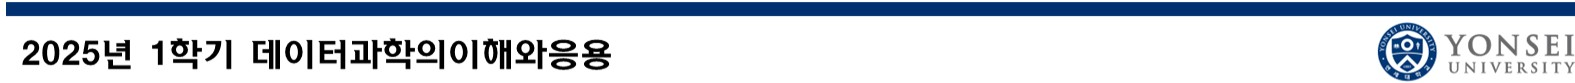

### 주어진 데이터는 생활 습관에 따른 행복도 조사를 위해 참여한 참가자들의 데이터와 만족도를 기록한 것입니다. 'train.csv'를 이용하여 분류모델을 생성하고 'test.csv'를 분류모델에 입력하여 만족도를 예측하세요


|column|description|
|-|-|
|id|참가자 번호|
|age|나이|
|gender|성별(남:M, 여:F)|
|smartphone_usage|주당 평균 커뮤너티, 유튜브, SNS 이용시간|
|sleeping_hour|평균 수면 시간|
|status_text|현재 자신의 감정상태를 표현한 텍스트|
|satisfaction|만족도(0:불만족, 1:보통, 2:만족)|

In [1]:
if __name__ == "__main__" and 'executed' not in globals():
    import warnings
    warnings.filterwarnings('ignore')
    from urllib.request import urlretrieve
    base_url = "https://swclass.yonsei.ac.kr:2020/dev/web/1104/"
    urlretrieve(base_url + "15_train.csv", "train.csv") # 학습 데이터 파일
    urlretrieve(base_url + "15_test.csv", "test.csv")   # 테스트 데이터 파일
    urlretrieve(base_url + "15_submit_form.csv", "submit_form.csv") # 제출 양식 파일
    executed = True
else:
    print('이미 데이터를 다운로드 하였으므로 다시 다운받지 않습니다. 데이터를 다시 다운받으려면 런타임 - 세션 다시 시작을 하세요')

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# 필요한 라이브러리가 있으면 자유롭게 추가로 import 할 수 있습니다.

df1 = pd.read_csv("train.csv", encoding='euc-kr') # 학습 데이터셋
df2 = pd.read_csv("test.csv", encoding='euc-kr') # 테스트 데이터셋(클래스값이 NaN으로 되어있습니다)

size = df1.shape[0] # 학습 데이터셋 크기

df = pd.concat([df1, df2], ignore_index=True) # 작성 편의를 위해 하나의 df로 병합



# **Data Preparation**
+ 자료형 확인

In [ ]:
df.dtypes

,0
id,int64
age,int64
gender,object
smartphone_usage,object
sleeping_hour,object
status_text,object
satisfaction,float64


+ 인코딩
+ 결측값 처리
+ 기타 필요한 처리

,id,age,gender,smartphone_usage,sleeping_hour,status_text,satisfaction
0,1,49,F,"커뮤니티 16시간, 유튜브 15시간, SNS 8시간",5시간~6시간,무기력~한 이 상태에서 벗어나고 싶다,0.0
1,2,46,F,"커뮤니티 16시간, 유튜브 33시간, SNS 25시간",4시간~5시간,오늘은 유난히 평소~의 기분이 좋았다,0.0
2,3,47,M,"커뮤니티 29시간, 유튜브 10시간, SNS 26시간",4시간~5시간,불안~한 꿈속으로 내가 빠져버린 것 같다,0.0
3,4,32,M,"커뮤니티 13시간, 유튜브 7시간, SNS 19시간",5시간~6시간,나무 그늘에서 평온~하게 독서를 하였다,0.0
4,5,23,F,"커뮤니티 21시간, 유튜브 8시간, SNS 30시간",4시간~5시간,오늘 결국엔 아무 일 없이 평온~했다,0.0
...,...,...,...,...,...,...,...
1995,1996,22,F,"커뮤니티 20시간, 유튜브 13시간, SNS 1시간",5시간~6시간,소중한 사람과의 즐거움~이 필요해,NaN
1996,1997,37,F,"커뮤니티 2시간, 유튜브 22시간, SNS 13시간",6시간~7시간,무기력~함에 사로잡혀 시간만 흘러간다,NaN
1997,1998,24,M,"커뮤니티 5시간, 유튜브 12시간, SNS 19시간",9시간 초과,이런 평온~한 날들이 계속되길 바란다,NaN
1998,1999,43,M,"커뮤니티 9시간, 유튜브 7시간, SNS 7시간",9시간 초과,평온~한 상태를 유지하고 싶다,NaN


In [3]:
# 추가 작업을 위한 셀

df.gender = df.gender.fillna("F")


df.status_text = df.status_text.str.extract("([가-힣]+)~")
df.smartphone_usage = df.smartphone_usage.astype(str)
df.smartphone_usage = df.smartphone_usage.str.extract("커뮤니티 ([0-9]+)시간").astype(int)+df.smartphone_usage.str.extract("유튜브 ([0-9]+)시간").astype(int)+df.smartphone_usage.str.extract("SNS ([0-9]+)시간").astype(int)


df["nage"] = pd.cut(df.age, bins=[-1, 20, 25, 30, 35, 40, 45, 50], labels=[0,1,2,3,4,5,6])
df["ngender"] = df.gender.replace(["M" , "F"], [0,1])
df["nsmartphone_usage"] = pd.qcut(df.smartphone_usage, q=[0,0.25,0.5,0.75,1], labels=[0,1,2,3])
df["nsleeping_hour"] = df.sleeping_hour.map({"4시간 미만":0, "4시간~5시간":0, "5시간~6시간":0, "6시간~7시간":2, "7시간~8시간":4, "8시간~9시간":3, "9시간 초과":1 })
df["nstatus_text"] = df.status_text.map({"기쁨":0 , "즐거움":0 , "설렘":0 , "웃음":0, "평소":1,
                                        "평온":1, "평범":1, "일상적":1, "무기력":2, "쓸쓸함":2, "불안":2, "우울":2})

Statusdf_train = df.dropna(subset=["status_text"])
Statusdf_test = df[df["status_text"].isna()]

StatusX_train = Statusdf_train.drop(columns=['id', 'age', 'gender', 'smartphone_usage',
             'sleeping_hour', 'status_text', 'satisfaction','nstatus_text'])
Statusy_train = Statusdf_train.nstatus_text
StatusX_test = Statusdf_test.drop(columns=['id', 'age', 'gender', 'smartphone_usage',
             'sleeping_hour', 'status_text', 'satisfaction', 'nstatus_text'])

Statusresult = RandomForestClassifier(max_depth=3,random_state=1).fit(StatusX_train,Statusy_train)
Statusy_pred = Statusresult.predict(StatusX_test).astype(int)

df.loc[df["nstatus_text"].isna(),'nstatus_text'] = Statusy_pred
df





,id,age,gender,smartphone_usage,sleeping_hour,status_text,satisfaction,nage,ngender,nsmartphone_usage,nsleeping_hour,nstatus_text
0,1,49,F,39,5시간~6시간,무기력,0.0,6,1,1,0,2.0
1,2,46,F,74,4시간~5시간,평소,0.0,6,1,3,0,1.0
2,3,47,M,65,4시간~5시간,불안,0.0,6,0,3,0,2.0
3,4,32,M,39,5시간~6시간,평온,0.0,3,0,1,0,1.0
4,5,23,F,59,4시간~5시간,평온,0.0,1,1,3,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,22,F,34,5시간~6시간,즐거움,NaN,1,1,1,0,0.0
1996,1997,37,F,37,6시간~7시간,무기력,NaN,4,1,1,2,2.0
1997,1998,24,M,36,9시간 초과,평온,NaN,1,0,1,1,1.0
1998,1999,43,M,23,9시간 초과,평온,NaN,5,0,0,1,1.0


# **EDA**
+ 예) 클래스 개수 파악

,id,age,gender,smartphone_usage,sleeping_hour,status_text,satisfaction,nage,ngender,nstatus_text,nsmartphone_usage,nsleeping_hour
0,1,49,F,39,5시간~6시간,무기력,0.0,2,1,2,1,0
1,2,46,F,74,4시간~5시간,평소,0.0,2,1,1,3,0
2,3,47,M,65,4시간~5시간,불안,0.0,2,0,2,3,0
3,4,32,M,39,5시간~6시간,평온,0.0,1,0,1,1,0
4,5,23,F,59,4시간~5시간,평온,0.0,1,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,22,F,34,5시간~6시간,즐거움,NaN,1,1,0,1,0
1996,1997,37,F,37,6시간~7시간,무기력,NaN,2,1,2,1,2
1997,1998,24,M,36,9시간 초과,평온,NaN,1,0,1,1,1
1998,1999,43,M,23,9시간 초과,평온,NaN,2,0,1,0,1


+ 예) 나이와 만족도 간의 관계

<Axes: xlabel='sleeping_hour', ylabel='satisfaction'>

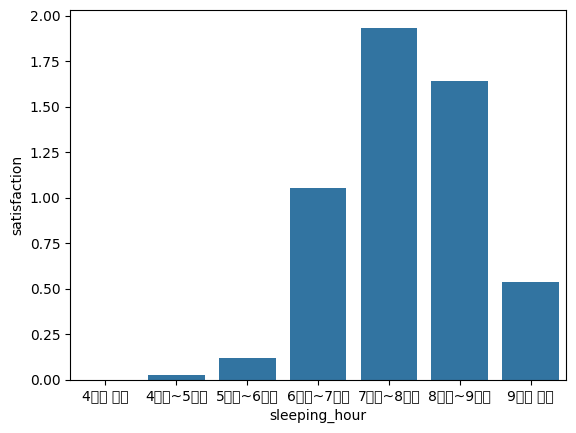

# **Machine Learning**

In [4]:
# 기존 컬럼을 삭제하고 필요한 컬럼만 남겨둔다
to_remove = ['id', 'age', 'gender', 'smartphone_usage',
             'sleeping_hour', 'status_text', 'satisfaction']

X_train = df[:size].drop(columns=to_remove)
y_train = df[:size].satisfaction
X_test = df[size:].drop(columns=to_remove)
y_test = df[size:].satisfaction

# 학습 데이터값 확인
X_train.head()

,nage,ngender,nsmartphone_usage,nsleeping_hour,nstatus_text
0,6,1,1,0,2.0
1,6,1,3,0,1.0
2,6,0,3,0,2.0
3,3,0,1,0,1.0
4,1,1,3,0,1.0


In [5]:
# 학습 데이터의 클래스값 확인
y_train.head()

,satisfaction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


+ 여러가지 머신러닝 모델로 학습 데이터셋에 대해 교차검증을 수행하며 성능이 좋은 것을 찾는다

In [ ]:
from random import Random
# 필요한 머신러닝 함수 혹은 하이퍼패러미터를 추가하거나 불필요한 함수를 삭제하는 등 자유롭게 수정하세요
dt=DecisionTreeClassifier(random_state=1)
ada=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                             n_estimators=200, learning_rate=1, random_state=1)
rf=RandomForestClassifier(max_depth=3, random_state=1)
estimator1 = [("dt",dt),("rf",rf),("ada",ada)]
vt=VotingClassifier(estimators=estimator1, voting="hard")
estimator2 = [("rf",rf),("vt",vt)]

classifiers = {"DecisionTree":DecisionTreeClassifier(random_state=1),
               "AdaBoost":AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                             n_estimators=100, learning_rate=1, random_state=1),
               "RandomForest": RandomForestClassifier(max_depth=3, random_state=1),
               "Voting": VotingClassifier(estimators=estimator1, voting="hard"),
               "Stacking":StackingClassifier(estimators=estimator2)
               }



# clfs에 나열된 항목에 대해 차례로 교차검증 수행
for name, clf in classifiers.items():
    print(name, cross_val_score(clf, X_train, y_train).mean().round(3))

DecisionTree 0.878
AdaBoost 0.88
RandomForest 0.875
Voting 0.899


+ 가장 결과가 잘 나오는 모델을 피팅하여 result 변수에 넣고 테스트 데이터를 입력하여 예측 결과를 y_pred에 생성한다

In [ ]:
# 다음은 예시 모델입니다. 자신의 분류모델과 패러미터로 수정하세요
result = StackingClassifier(estimators=estimator2).fit(X_train, y_train) # 교체할 것

y_pred = result.predict(X_test).astype(int) # 완성된 코드

print(y_pred[:10]) # 지면상 첫 10개만 출력

[1 1 1 0 0 1 1 1 0 2]


# **Submission**
+ 1) 아래 셀을 실행하여 생성된 파일을 다운로드 하여 캐글에 제출
  + 코드에서 filename을 학번으로 변경
  + 캐글의 Team Name을 학번의 마지막 4자리로 변경(미변경시 미제출처리)
+ 2) 본 노트북 파일을 과제 사이트의 15주차에 제출(기한 이후 제출시 감점)
+ 3) 아래 출력되는 링크에서 반드시 제출 기한, 채점 기준 등을 확인

In [ ]:
submit_form = pd.read_csv("submit_form.csv") # 답안 양식을 불러온다.
submit_form["satisfaction"] = y_pred # 이전 셀에서 생성한 답안을 입력

# X부분의 학번을 정확히 작성 (추가 정보는 _로 붙일 수 있습니다)
# 예) "2025112345_SVC_ver1.0"
filename = "2025122028"

# 캐글에 제출할 파일 생성(왼쪽 드라이브 폴더에서 다운로드 하여 제출)
submit_form.to_csv(f"{filename}.csv", index=False)

# 출력된 링크를 클릭하여 제출 방법 등 확인
print('과제 제출을 위해 kaggle.com에 가입합니다(필수)')
print("https://www.kaggle.com/t/7789925876b74fd3a0d87bc828711c86")

과제 제출을 위해 kaggle.com에 가입합니다(필수)
https://www.kaggle.com/t/7789925876b74fd3a0d87bc828711c86


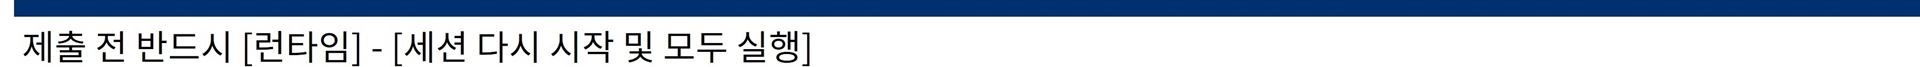

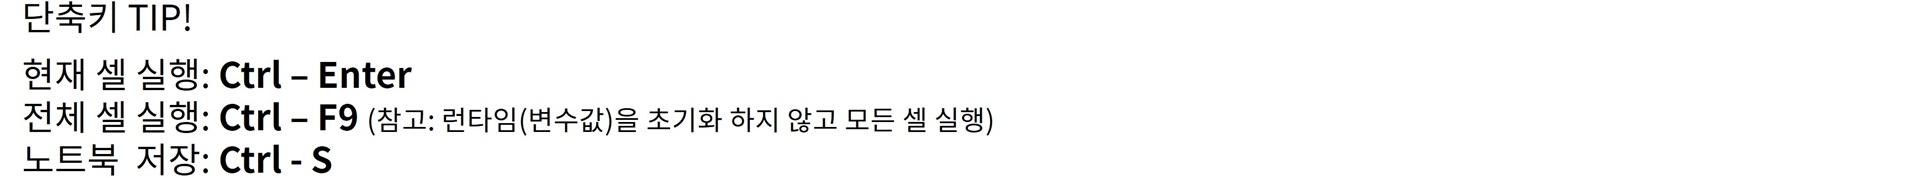